# Língua Brasileira de Sinais - Identificando as letras do alfabeto

Este trabalho tem como objetivo, dada uma imagem, identificar a qual letra ela corresponde na Língua Brasileira de Sinais (Libras).

Para isto, utilizou-se um dataset extraído do [Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) contendo pelo menos 86 mil imagens correspondentes às representações das letras do alfabeto em Libras. Também utilizou-se um [tutorial do Kaggle](https://www.kaggle.com/code/davinsthomas/cnn-adaptive-aug-template) para auxiliar no passo a passo deste trabalho, principalmente com a parte inicial de leitura dos arquivos.

Abaixo segue uma imagem dos símbolos correspondente a cada letra na Língua Brasileira de Sinais:

<img src="https://s1.static.brasilescola.uol.com.br/img/2019/09/alfabeto.png">

Para este problema, utilizou-se a CNN (rede neural convolucional), ideal para realizar a classificação de imagens.

## Bibliotecas

In [ ]:
from google.colab import drive
from zipfile import ZipFile
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
import sklearn
import plotly.express as px

## Leitura da base de dados

### Acessando arquivos no drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = '/content/drive/MyDrive/dataset/archive.zip'

### Extraindo arquivos de `arquive.zip`

In [ ]:
zf = ZipFile(dataset, 'r')
zf.extractall('base_de_dados')
zf.close()

In [ ]:
train_folder = 'base_de_dados/asl_alphabet_train/asl_alphabet_train'

class_names = sorted(os.listdir(train_folder))
print(f"Classes : \n{class_names}\n")

n_classes = len(class_names)
print(f"Número total de classes : {n_classes}")

Classes : 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Número total de classes : 29


## Visualização dos dados

In [ ]:
class_dis = [len(os.listdir(train_folder + '/' + name)) for name in class_names]

# Pie Plot 
fig = px.pie(names=class_names, values=class_dis, title="Distribuição das classes", hole=0.2)
fig.show()

Exemplos de imagens da base de dados

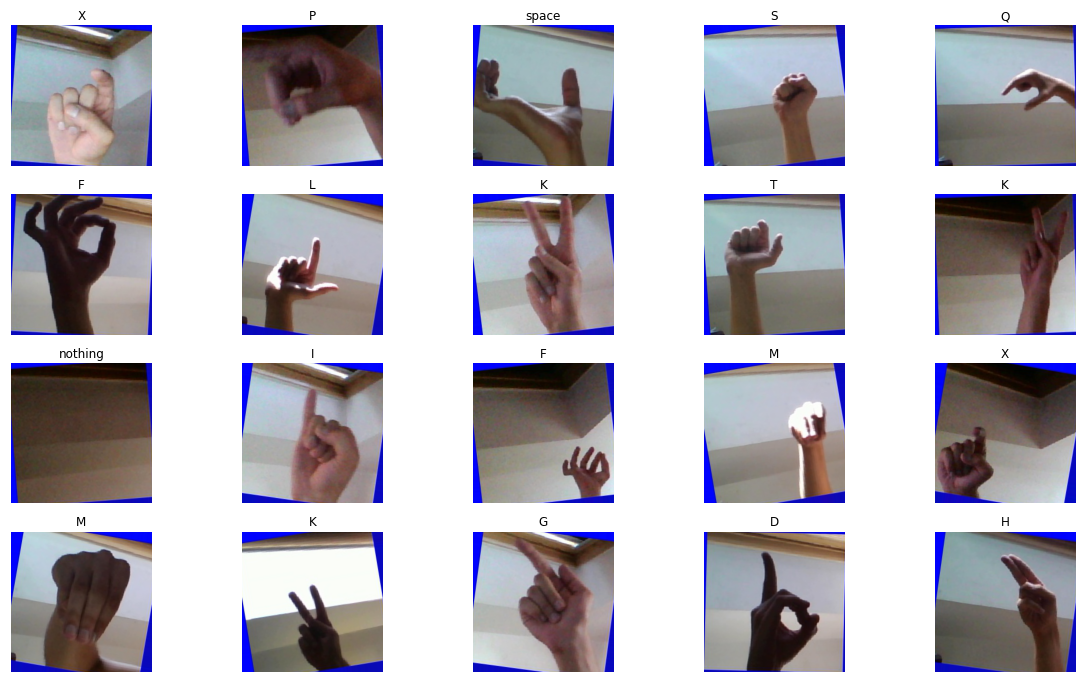

## Tratamento das imagens e divisão dos dados

*   Diminuindo o tamanho das imagens: de 256x256 para 64x64;
*   Atribuindo as labels de 0 a 29 para classificar as imagens;
*   Escalonamento das imagens (pixels que estavam entre `0-255` ficam entre `0-1`);
*   Dividindo os dados entre treino e teste.
*   Aplicação da estratégia _data augmentation_

In [ ]:
def carregar_imagens():
    images = []
    labels = []
    index = 0
    folders = sorted(os.listdir(train_folder))
    
    for folder in folders:   
        print("Iniciando tratamento das imagens da pasta  ", folder)
        for image in os.listdir(train_folder + '/' + folder):
            img = cv2.imread(train_folder + '/' + folder + '/' + image, 0)
            img = cv2.resize(img, (64, 64))
            img = img_to_array(img)
            images.append(img)
            labels.append(index)
        index += 1

    images = np.array(images)
    images = images.astype('float32')/255.0
    labels = to_categorical(labels)

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)

    return x_train, x_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = carregar_imagens()

Iniciando tratamento das imagens da pasta   A
Iniciando tratamento das imagens da pasta   B
Iniciando tratamento das imagens da pasta   C
Iniciando tratamento das imagens da pasta   D
Iniciando tratamento das imagens da pasta   E
Iniciando tratamento das imagens da pasta   F
Iniciando tratamento das imagens da pasta   G
Iniciando tratamento das imagens da pasta   H
Iniciando tratamento das imagens da pasta   I
Iniciando tratamento das imagens da pasta   J
Iniciando tratamento das imagens da pasta   K
Iniciando tratamento das imagens da pasta   L
Iniciando tratamento das imagens da pasta   M
Iniciando tratamento das imagens da pasta   N
Iniciando tratamento das imagens da pasta   O
Iniciando tratamento das imagens da pasta   P
Iniciando tratamento das imagens da pasta   Q
Iniciando tratamento das imagens da pasta   R
Iniciando tratamento das imagens da pasta   S
Iniciando tratamento das imagens da pasta   T
Iniciando tratamento das imagens da pasta   U
Iniciando tratamento das imagens d

In [ ]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'

train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow(
    X_train, y_train, batch_size=batch_size, shuffle = False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow(
    X_test, y_test, batch_size=batch_size, shuffle=False
)

## Verificando o tamanho dos datasets de treino e teste

In [ ]:
print(f'Tamanho do X_train: {X_train.shape}')
print(f'Tamanho do y_train: {y_train.shape}')
print(f'Tamanho do X_test: {X_test.shape}')
print(f'Tamanho do y_test: {y_test.shape}')

Tamanho do X_train: (78300, 64, 64, 1)
Tamanho do y_train: (78300, 29)
Tamanho do X_test: (8700, 64, 64, 1)
Tamanho do y_test: (8700, 29)


## Projetando a rede neural

In [ ]:
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
                  10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
                  19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [ ]:
model = Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 32)         0

In [ ]:
classes = 29
epochs = 10

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
2447/2447 [==============================] - 25s 7ms/step - loss: 0.8220 - accuracy: 0.7488 - val_loss: 0.1961 - val_accuracy: 0.9326
Epoch 2/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.1376 - accuracy: 0.9557 - val_loss: 0.0666 - val_accuracy: 0.9797
Epoch 3/10
2447/2447 [==============================] - 16s 6ms/step - loss: 0.0730 - accuracy: 0.9771 - val_loss: 0.0670 - val_accuracy: 0.9787
Epoch 4/10
2447/2447 [==============================] - 16s 6ms/step - loss: 0.0592 - accuracy: 0.9826 - val_loss: 0.0360 - val_accuracy: 0.9897
Epoch 5/10
2447/2447 [==============================] - 16s 6ms/step - loss: 0.0433 - accuracy: 0.9875 - val_loss: 0.0608 - val_accuracy: 0.9826
Epoch 6/10
2447/2447 [==============================] - 16s 7ms/step - loss: 0.0376 - accuracy: 0.9894 - val_loss: 0.0426 - val_accuracy: 0.9895
Epoch 7/10
2447/2447 [==============================] - 15s 6ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.2448 - val_ac

## Visualização das métricas

### Curva de acurácia

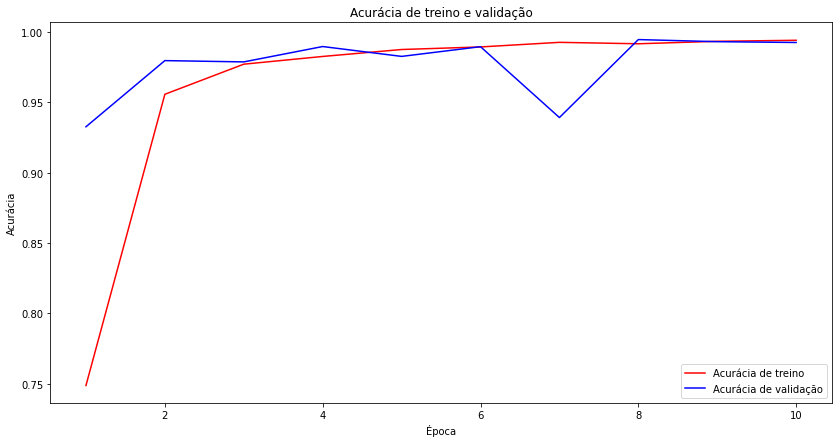

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

epochs=[i for i in range(1,11)]

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Acurácia de treino")
plt.plot(epochs, val_acc, 'b', label="Acurácia de validação")
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia de treino e validação')
plt.legend(loc='lower right')
plt.show()

### Curva de perda

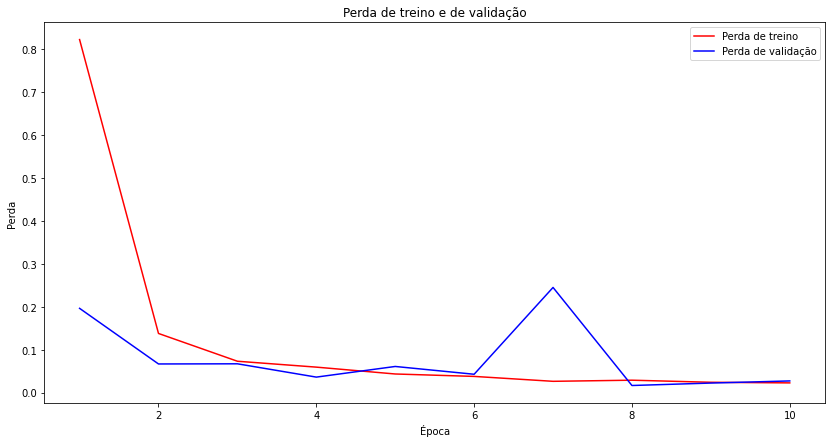

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=[i for i in range(1,11)]

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Perda de treino")
plt.plot(epochs, val_loss, 'b', label="Perda de validação")
plt.legend(loc='upper right')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de treino e de validação')
plt.show()

### Classification report

In [ ]:
class_labels = list(map_characters.values())

y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred, axis=1) 
Y_true = np.argmax(y_test, axis=1) 

report = metrics.classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           A       0.99      0.98      0.98       315
           B       1.00      1.00      1.00       289
           C       1.00      1.00      1.00       285
           D       1.00      1.00      1.00       299
           E       0.99      0.98      0.99       290
           F       0.98      0.99      0.99       318
           G       0.99      1.00      1.00       302
           H       1.00      0.98      0.99       302
           I       0.99      1.00      0.99       310
           J       0.99      1.00      0.99       314
           K       1.00      0.97      0.98       306
           L       1.00      1.00      1.00       299
           M       1.00      0.99      1.00       302
           N       1.00      0.99      0.99       295
           O       1.00      1.00      1.00       295
           P       1.00      1.00      1.00       289
           Q       1.00   

### Matriz de confusão

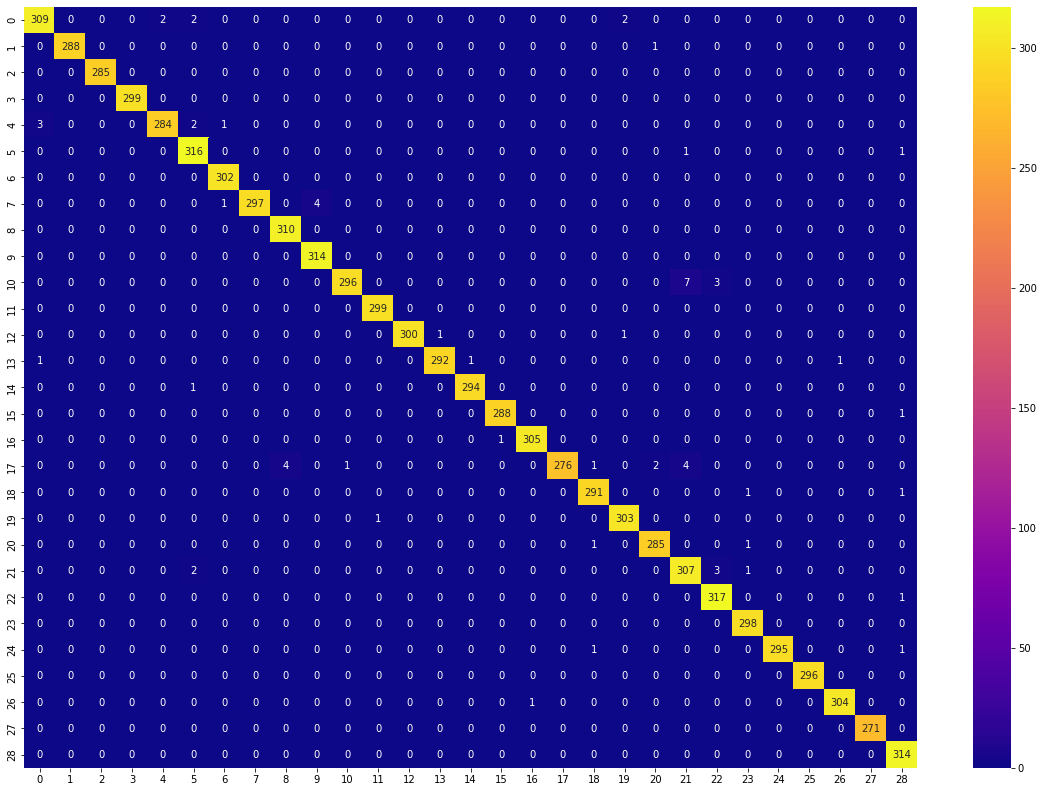

In [ ]:
confusion = metrics.confusion_matrix(Y_true,Y_pred_classes)
plt.figure(figsize=(20, 14))
sns.heatmap(confusion, cmap="plasma", annot=True, fmt = 'd')
plt.show()